### What would be an appropriate metric to evaluate your models? Why? (Hint: No code required.)

[Add answer]

### Get the data and show some example images from the data.

In [1]:
%%capture
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

In [2]:
from keras.datasets import fashion_mnist

# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [3]:
# Look at the dimensions
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_test:  {y_test.shape}")

X_train: (60000, 28, 28)
y_train: (60000,)
X_test:  (10000, 28, 28)
y_test:  (10000,)


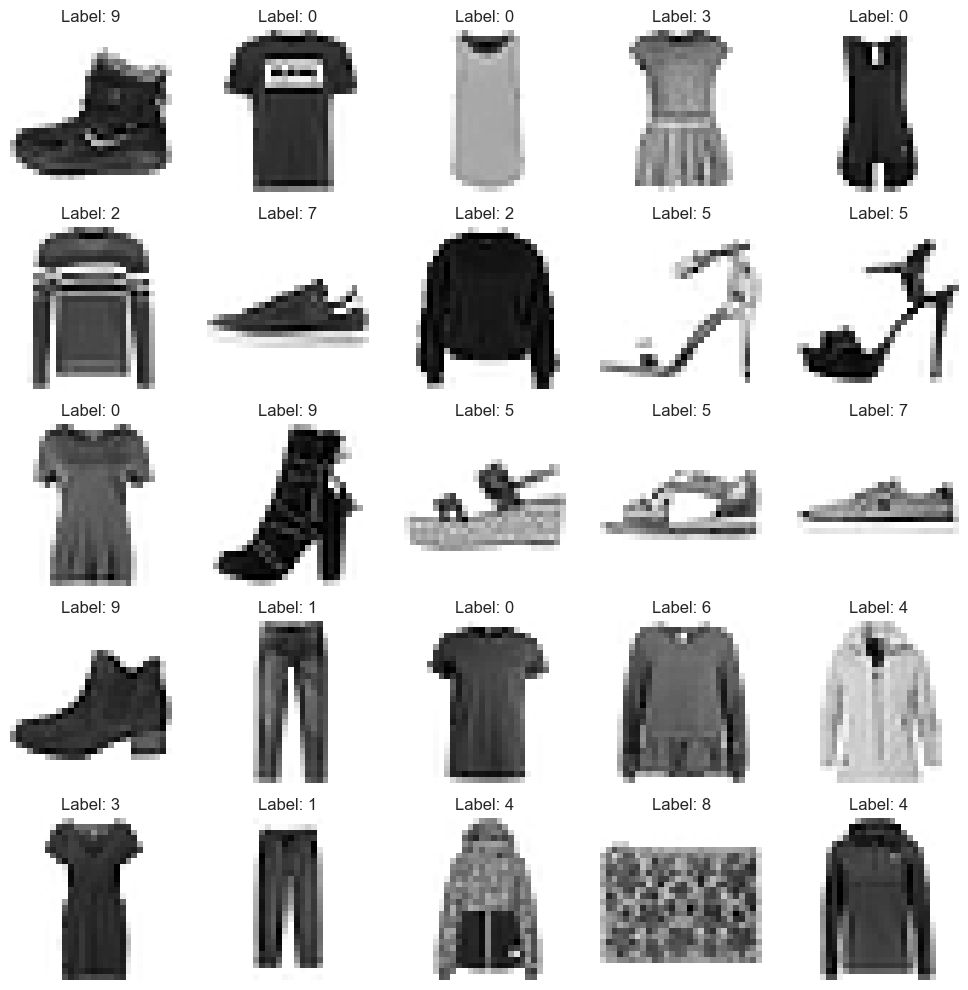

In [4]:
# Visualize some items in a grid
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 5, figsize=(10,10))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(X_train[i], cmap="binary")
    ax.axis("off")
    ax.set_title(f"Label: {y_train[i]}")
plt.tight_layout()
plt.show()

### Train a simple fully connected single hidden layer network to predict the items. Remember to normalize the data similar to what we did in class. Make sure that you use enough epochs so that the validation error begins to level off - provide a plot of the training history.

In [5]:
from sklearn.model_selection import train_test_split

prng = np.random.RandomState(20240329)  # ensure we have the same split as in last class

# intentionally choose a small train set to decrease computational burden
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=prng)

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val:  {X_val.shape}")
print(f"y_val:  {y_val.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_test:  {y_test.shape}")

X_train: (42000, 28, 28)
y_train: (42000,)
X_val:  (18000, 28, 28)
y_val:  (18000,)
X_test:  (10000, 28, 28)
y_test:  (10000,)


In [6]:
# Benchmark #1 (silly):

from sklearn.metrics import accuracy_score
from statistics import mode

most_frequent = mode(y_train)
print(f"Most frequent element is: {most_frequent}")
accuracy_most_frequent = accuracy_score(y_val, np.repeat(most_frequent, len(y_val)))
print(f"Accuracy for our no-brainer model: {round(accuracy_most_frequent, 4)}")
summary_df = pd.DataFrame({'Model': ['Benchmark'],
                           'Train accuracy': [round(accuracy_score(np.array([most_frequent] * len(y_train)), y_train), 4)],
                           'Val accuracy': [round(accuracy_score(np.array([most_frequent] * len(y_val)), y_val), 4)],
                           'Test accuracy': [round(accuracy_score(np.array([most_frequent] * len(y_test)), y_test), 4)],
                          })
summary_df

Most frequent element is: 7
Accuracy for our no-brainer model: 0.0944


,Model,Train accuracy,Val accuracy,Test accuracy
0,Benchmark,0.1024,0.0944,0.1


In [7]:
def update_summary(summary_df, model_name, train_score, val_score, test_score):
    if model_name not in summary_df.Model.values:
        summary_df.loc[len(summary_df.index)] = [model_name, 
                                                 '{:.4f}'.format(train_score),
                                                 '{:.4f}'.format(val_score),
                                                 '{:.4f}'.format(test_score)]
    else:
        summary_df.loc[summary_df.Model == model_name] = [model_name, 
                                                 '{:.4f}'.format(train_score),
                                                 '{:.4f}'.format(val_score),
                                                 '{:.4f}'.format(test_score)]

In [8]:
from sklearn.pipeline import Pipeline
# Benchmark #2 (RF):
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer

def flatten_data(X):
    return X.reshape(X.shape[0], -1)

transformer = FunctionTransformer(flatten_data)

rf_model = Pipeline(
    [("preprocess", transformer),
     ("rf", RandomForestClassifier(random_state = prng))
     ], verbose=True
)

rf_model.fit(X_train, y_train)
predictions_rf = rf_model.predict(X_val)
accuracy_score(y_val, predictions_rf)

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing rf, total=  48.1s


0.8811666666666667

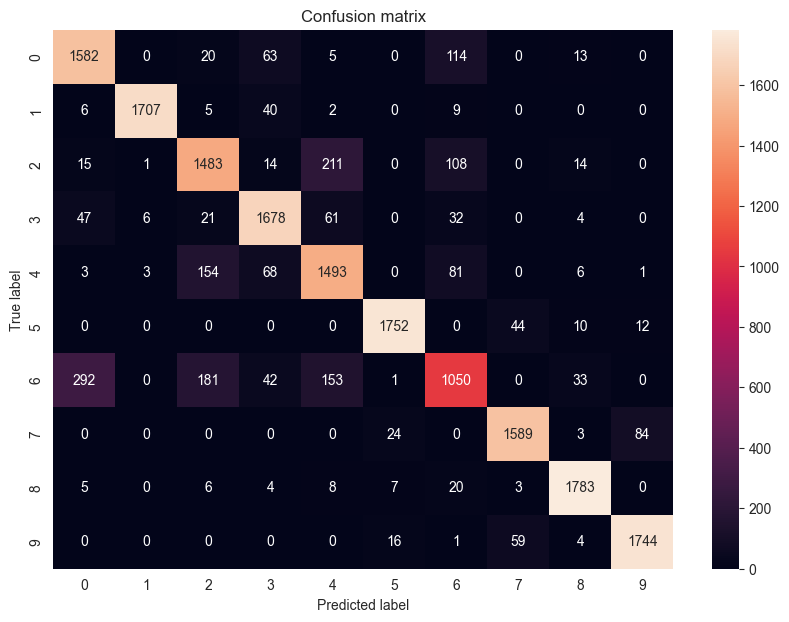

In [9]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, predictions_rf)

# # visualize with seaborn
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [10]:
update_summary(summary_df, 'Random Forest', accuracy_score(y_train, rf_model.predict(X_train)), accuracy_score(y_val, predictions_rf), accuracy_score(y_test, rf_model.predict(X_test)))
summary_df

,Model,Train accuracy,Val accuracy,Test accuracy
0,Benchmark,0.1024,0.0944,0.1
1,Random Forest,1.0000,0.8812,0.8699


In [11]:
from keras.utils import to_categorical

print(f"Dimension of y: {y_train.shape}")

# Convert target variables to categorical
num_classes = 10
y_sets = [y_train, y_test, y_val]
y_train, y_test, y_val = [to_categorical(y, num_classes=num_classes) for y in y_sets]
print(f"Dimension of y: {y_train.shape}")

Dimension of y: (42000,)
Dimension of y: (42000, 10)


In [12]:
from keras.models import Sequential
from keras.layers import Input, Flatten, Rescaling, Dense
from keras.utils import to_categorical

# Build the simple fully connected single hidden layer network model
model = Sequential([
    Input(shape=X_train.shape[1:]), 
    Flatten(), 
    Rescaling(1./255), 
    Dense(255, activation='relu'), 
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 255)            │       200,175 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,735 (791.93 KB)

 Trainable params: 202,735 (791.93 KB)

 Non-trainable params: 0 (0.00 B)

None


In [13]:
import keras

# Fit the model
keras.utils.set_random_seed(20240329)  # for reproducibility
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=512)

Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6607 - loss: 1.0471 - val_accuracy: 0.8169 - val_loss: 0.5263
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8282 - loss: 0.4949 - val_accuracy: 0.8310 - val_loss: 0.4749
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8480 - loss: 0.4381 - val_accuracy: 0.8383 - val_loss: 0.4527
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8567 - loss: 0.4077 - val_accuracy: 0.8466 - val_loss: 0.4294
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8660 - loss: 0.3812 - val_accuracy: 0.8537 - val_loss: 0.4095
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8730 - loss: 0.3600 - val_accuracy: 0.8584 - val_loss: 0.3934
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8791 - loss: 0.3427 - val_accuracy: 0.8614 - val_loss: 0.3840
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8839 - loss: 0.3285 - val_accuracy: 0.8666 - v

In [14]:
# Evaluation of the model on the validation set
scores = model.evaluate(X_val, y_val)
print(f"Accuracy for keras single hidden layer: {round(scores[1], 4)}")

563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - accuracy: 0.8834 - loss: 0.4858
Accuracy for keras single hidden layer: 0.885


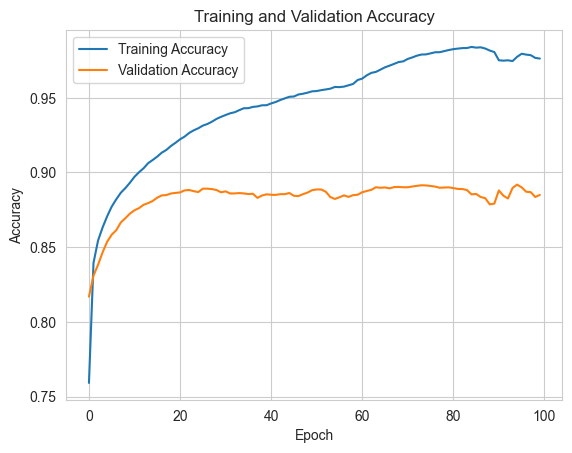

In [15]:
def plot_history(fit_history):
    plt.plot(fit_history['accuracy'], label='Training Accuracy')
    plt.plot(fit_history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

plot_history(history.history)

In [16]:
update_summary(summary_df, 'Single Hidden Layer', model.evaluate(X_train, y_train)[1], scores[1], model.evaluate(X_test, y_test)[1])
summary_df

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step - accuracy: 0.9670 - loss: 0.0913
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - accuracy: 0.8747 - loss: 0.5226


,Model,Train accuracy,Val accuracy,Test accuracy
0,Benchmark,0.1024,0.0944,0.1
1,Random Forest,1.0000,0.8812,0.8699
2,Single Hidden Layer,0.9663,0.8850,0.8762


### Experiment with different network architectures and settings (number of hidden layers, number of nodes, regularization, etc.). Train at least 3 models. Explain what you have tried and how it worked.

In [22]:
# Build the fully connected 3 hidden layers network model
hidden3_model = Sequential([
    Input(shape=X_train.shape[1:]), 
    Flatten(), 
    Rescaling(1./255), 
    Dense(255, activation='relu'), 
    Dense(255, activation='relu'), 
    Dense(255, activation='relu'), 
    Dense(num_classes, activation='softmax')
])

# Compile the model
hidden3_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 255)            │       200,175 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 608,207 (2.32 MB)

 Trainable params: 202,735 (791.93 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 405,472 (1.55 MB)

None


In [23]:
# Fit the model
keras.utils.set_random_seed(20240329)  # for reproducibility
hidden3_history = hidden3_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=512)

Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6665 - loss: 1.0288 - val_accuracy: 0.7771 - val_loss: 0.5799
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8233 - loss: 0.4867 - val_accuracy: 0.8059 - val_loss: 0.5105
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8491 - loss: 0.4154 - val_accuracy: 0.8284 - val_loss: 0.4531
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8642 - loss: 0.3746 - val_accuracy: 0.8454 - val_loss: 0.4178
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8752 - loss: 0.3445 - val_accuracy: 0.8602 - val_loss: 0.3756
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8841 - loss: 0.3175 - val_accuracy: 0.8725 - val_loss: 0.3462
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8921 - loss: 0.2941 - val_accuracy: 0.8758 - val_loss: 0.3387
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8970 - loss: 0.2788 - val_accuracy: 0.8786 - v

In [24]:
# Evaluation of the model on the validation set
hidden3_scores = hidden3_model.evaluate(X_val, y_val)
print(f"Accuracy for keras 3 hidden layers: {round(hidden3_scores[1], 4)}")

563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - accuracy: 0.8891 - loss: 0.7125
Accuracy for keras 3 hidden layers: 0.889


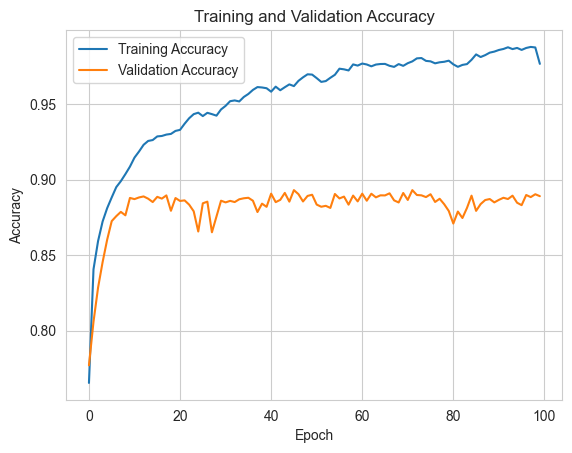

In [25]:
plot_history(hidden3_history.history)

In [26]:
update_summary(summary_df, '3 Hidden Layers', hidden3_model.evaluate(X_train, y_train)[1], hidden3_scores[1], hidden3_model.evaluate(X_test, y_test)[1])
summary_df

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 1s 896us/step - accuracy: 0.9744 - loss: 0.0738
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - accuracy: 0.8756 - loss: 0.8458


,Model,Train accuracy,Val accuracy,Test accuracy
0,Benchmark,0.1024,0.0944,0.1
1,Random Forest,1.0000,0.8812,0.8699
2,Single Hidden Layer,0.9663,0.8850,0.8762
3,3 Hidden Layers,0.9743,0.8890,0.8800
